<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

`Initial Inspection`

In [630]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

In [606]:
# Importing datasets 
path_frederik = "C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/Features data set.csv"
path_mathijs = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"

os.chdir(path_mathijs)
print(os.getcwd())

features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [607]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Cleaning`

In [608]:
# Dropping unnecessary columns
sales.drop(columns=['Dept'], inplace=True)

In [609]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [610]:
features['week'] = features.Date.dt.isocalendar().week
features['year'] = features.Date.dt.year
features['quarter'] = features.Date.dt.quarter
print(features.head())

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3   
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN  \
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  week  year   
0        NaN        NaN  211.096358         8.106      False     5  2010  \
1        NaN        NaN  211.242170         8.106       True     6  2010   
2        NaN        NaN  211.289143         8.106      False     7  2010   
3        NaN        NaN  211.319643         8.106      False     8  2010   
4        NaN        NaN  211.350143         8.106      False     9  2010   

   quarter  
0        1  
1        1  
2        1  
3   

In [611]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
print(features.head())
features.shape

   Store       Date  Temperature  Fuel_Price     MarkDown1   MarkDown3   
0      1 2010-02-05        42.31       2.572  24089.612333  198.031818  \
1      1 2010-02-12        38.51       2.548  29880.900556  197.092500   
2      1 2010-02-19        39.93       2.514  12536.748111   59.385610   
3      1 2010-02-26        46.63       2.561   8504.312444   25.995714   
4      1 2010-03-05        46.50       2.625  11293.039000   22.353662   

      MarkDown4    MarkDown5         CPI  Unemployment  IsHoliday  week  year   
0  24865.942619  4185.380333  211.096358         8.106      False     5  2010  \
1  20305.431829  5089.147556  211.242170         8.106       True     6  2010   
2   7038.310625  5646.276000  211.289143         8.106      False     7  2010   
3   2879.735679  4458.685000  211.319643         8.106      False     8  2010   
4   6312.144304  2911.005778  211.350143         8.106      False     9  2010   

   quarter  
0        1  
1        1  
2        1  
3        1  
4  

(8190, 14)

In [612]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [613]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')

print(
    df.head(), '\n',
    df.tail()
)

   Store  Type    Size       Date  Weekly_Sales  IsHoliday  Temperature   
0      1     0  151315 2010-02-05      24924.50          0        42.31  \
1      1     0  151315 2010-02-12      46039.49          1        38.51   
2      1     0  151315 2010-02-19      41595.55          0        39.93   
3      1     0  151315 2010-02-26      19403.54          0        46.63   
4      1     0  151315 2010-03-05      21827.90          0        46.50   

   Fuel_Price     MarkDown1   MarkDown3     MarkDown4    MarkDown5   
0       2.572  24089.612333  198.031818  24865.942619  4185.380333  \
1       2.548  29880.900556  197.092500  20305.431829  5089.147556   
2       2.514  12536.748111   59.385610   7038.310625  5646.276000   
3       2.561   8504.312444   25.995714   2879.735679  4458.685000   
4       2.625  11293.039000   22.353662   6312.144304  2911.005778   

          CPI  Unemployment  week  year  quarter  
0  211.096358         8.106     5  2010        1  
1  211.242170         8.10

`Exploratory Data Analysis`

In [614]:
df_date = df.groupby('Date').agg({'Temperature': 'mean',
                                       'Fuel_Price': 'mean',
                                       'CPI': 'mean',
                                       'Unemployment': 'mean', 
                                       'Weekly_Sales': 'mean',
                                       'IsHoliday': 'min',
                                       'MarkDown1': 'mean',
                                       'MarkDown3': 'mean',
                                       'MarkDown4': 'mean',
                                       'MarkDown5': 'mean'}).reset_index()
df_date.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,33.277942,2.717869,167.398405,8.576731,16836.121997,0,24089.612333,198.031818,24865.942619,4185.380333
1,2010-02-12,33.361810,2.696102,167.384138,8.567309,16352.056032,1,29880.900556,197.092500,20305.431829,5089.147556
2,2010-02-19,37.038310,2.673666,167.338966,8.576351,16216.658979,0,12536.748111,59.385610,7038.310625,5646.276000
3,2010-02-26,38.629563,2.685642,167.691019,8.561375,14899.549688,0,8504.312444,25.995714,2879.735679,4458.685000
4,2010-03-05,42.373998,2.731816,167.727351,8.572689,15921.015727,0,11293.039000,22.353662,6312.144304,2911.005778


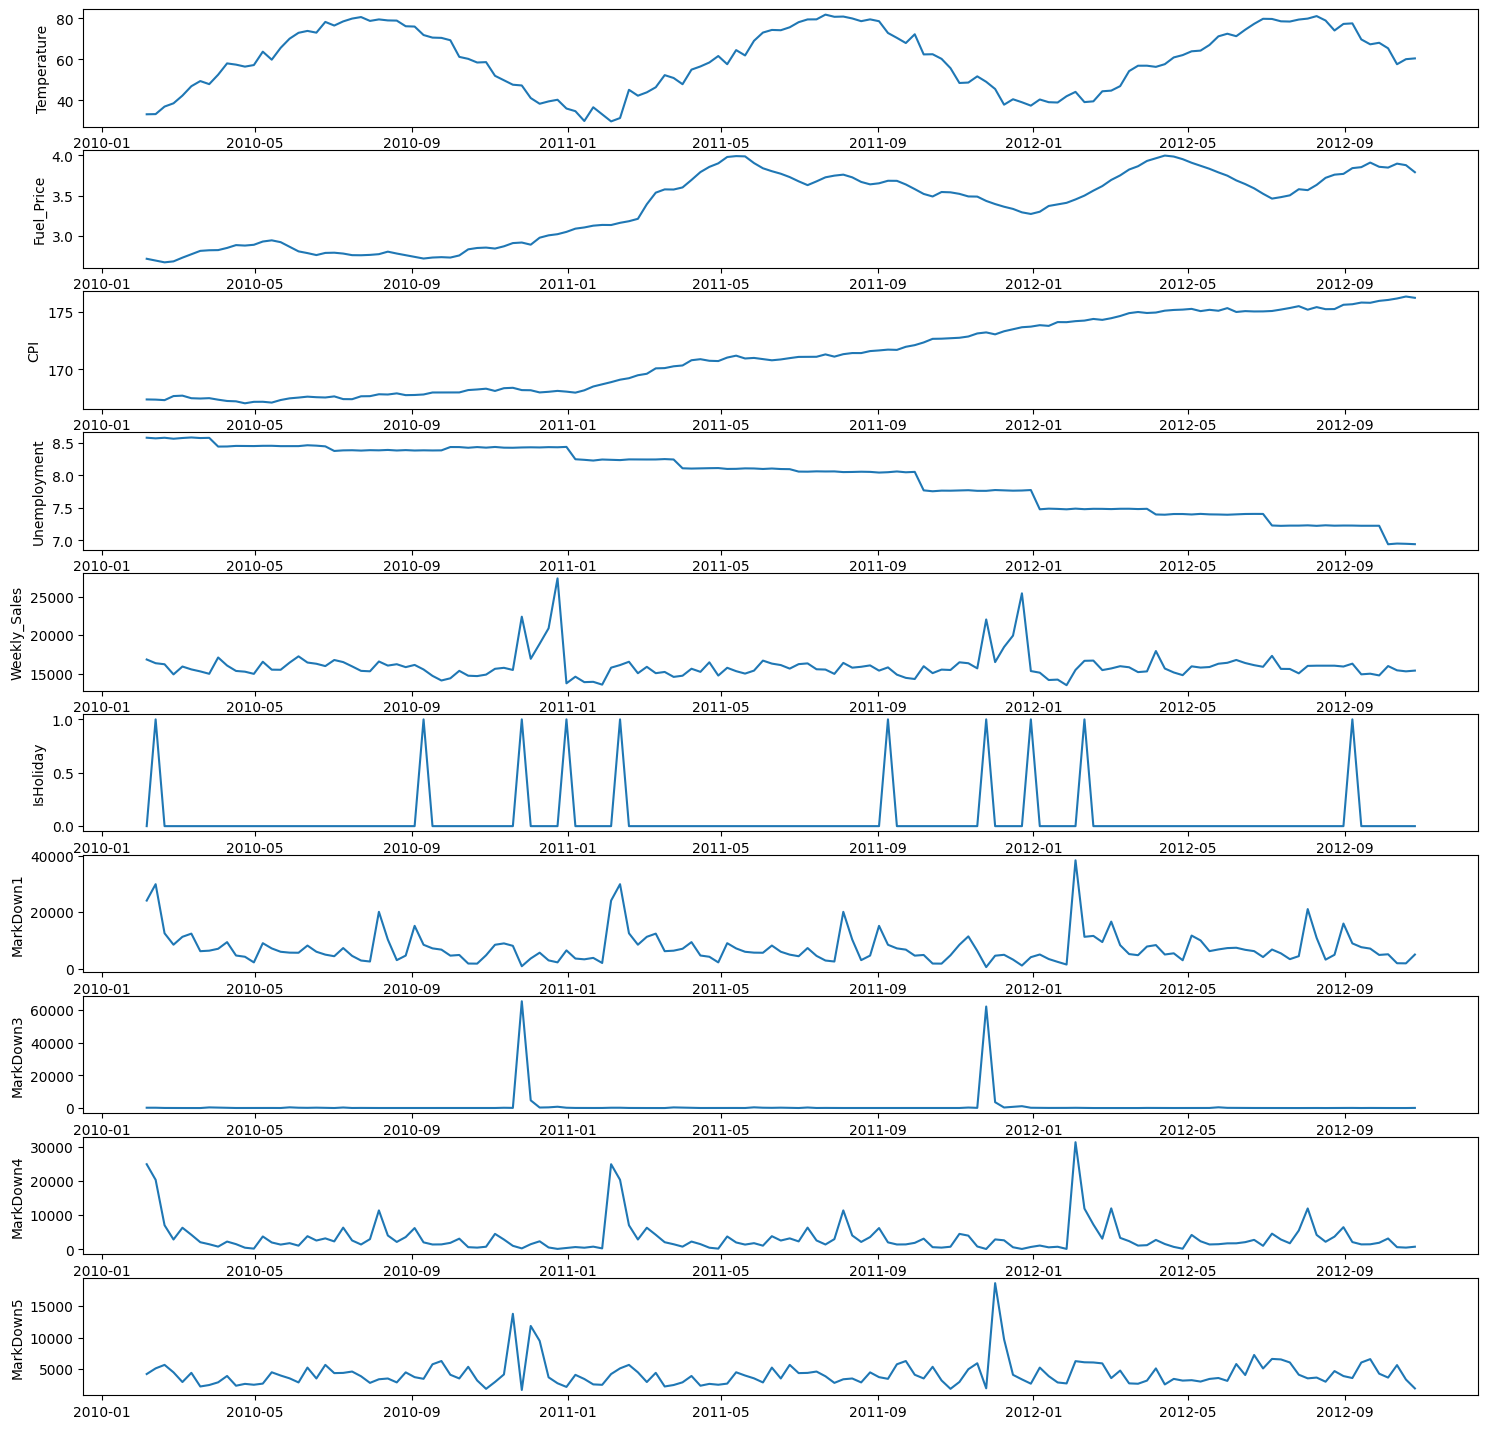

In [615]:
# Plotting all features
fig = plt.figure(figsize = (18, 18))
count_columns_ex_date = len(df_date.columns[1:])
for idx, col in enumerate(df_date.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(df_date["Date"], df_date[col])
    plt.ylabel(col)

## Prediction Models

`Feature Engineering and Data Preperation`

In [616]:
# Getting the specific store data 
# df_stores = df[df['Store'].isin([19, 5])]
df_stores = df

In [617]:
print(
    df.shape, '\n',
    df_stores.head()
)


(421570, 17) 
    Store  Type    Size       Date  Weekly_Sales  IsHoliday  Temperature   
0      1     0  151315 2010-02-05      24924.50          0        42.31  \
1      1     0  151315 2010-02-12      46039.49          1        38.51   
2      1     0  151315 2010-02-19      41595.55          0        39.93   
3      1     0  151315 2010-02-26      19403.54          0        46.63   
4      1     0  151315 2010-03-05      21827.90          0        46.50   

   Fuel_Price     MarkDown1   MarkDown3     MarkDown4    MarkDown5   
0       2.572  24089.612333  198.031818  24865.942619  4185.380333  \
1       2.548  29880.900556  197.092500  20305.431829  5089.147556   
2       2.514  12536.748111   59.385610   7038.310625  5646.276000   
3       2.561   8504.312444   25.995714   2879.735679  4458.685000   
4       2.625  11293.039000   22.353662   6312.144304  2911.005778   

          CPI  Unemployment  week  year  quarter  
0  211.096358         8.106     5  2010        1  
1  211.2421

#### Create dummies for years and weeks

In [618]:
# Create dummy variables for 'year' and 'week'
year_dummies = pd.get_dummies(df_stores['year'], prefix='year').astype(int)
week_dummies = pd.get_dummies(df_stores['week'], prefix='week').astype(int)
quarter_dummies = pd.get_dummies(df_stores['quarter'], prefix='quarter').astype(int)

# Ensure all years and weeks columns exist using reindex
desired_year_columns = [f'year_{i}' for i in range(2010, 2014)]
desired_week_columns = [f'week_{i}' for i in range(1, 53)]
desired_quarter_columns = [f'quarter_{i}' for i in range(1,5)]

year_dummies = year_dummies.reindex(columns=desired_year_columns, fill_value=0)
week_dummies = week_dummies.reindex(columns=desired_week_columns, fill_value=0)
quarter_dummies = quarter_dummies.reindex(columns=desired_quarter_columns, fill_value=0)

# Concatenate the dummy variables back to the original dataframe
df_stores = pd.concat([df_stores, year_dummies, week_dummies, quarter_dummies], axis=1)

print(df_stores.shape, '\n', df_stores.head())


(421570, 77) 
    Store  Type    Size       Date  Weekly_Sales  IsHoliday  Temperature   
0      1     0  151315 2010-02-05      24924.50          0        42.31  \
1      1     0  151315 2010-02-12      46039.49          1        38.51   
2      1     0  151315 2010-02-19      41595.55          0        39.93   
3      1     0  151315 2010-02-26      19403.54          0        46.63   
4      1     0  151315 2010-03-05      21827.90          0        46.50   

   Fuel_Price     MarkDown1   MarkDown3  ...  week_47  week_48  week_49   
0       2.572  24089.612333  198.031818  ...        0        0        0  \
1       2.548  29880.900556  197.092500  ...        0        0        0   
2       2.514  12536.748111   59.385610  ...        0        0        0   
3       2.561   8504.312444   25.995714  ...        0        0        0   
4       2.625  11293.039000   22.353662  ...        0        0        0   

   week_50  week_51  week_52  quarter_1  quarter_2  quarter_3  quarter_4  
0       

#### Store with the highest performance

In [619]:
# Splitting the data into train- and test set
split_indx = int(0.8*len(df_stores))

train = df_stores[:split_indx]
test = df_stores[split_indx:]

In [620]:
# Setting date as index 
train = train.set_index('Date')
test = test.set_index('Date')

In [621]:
train.head()

,Store,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,...,week_47,week_48,week_49,week_50,week_51,week_52,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,151315,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,...,0,0,0,0,0,0,1,0,0,0
2010-02-12,1,0,151315,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,...,0,0,0,0,0,0,1,0,0,0
2010-02-19,1,0,151315,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,...,0,0,0,0,0,0,1,0,0,0
2010-02-26,1,0,151315,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,...,0,0,0,0,0,0,1,0,0,0
2010-03-05,1,0,151315,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,...,0,0,0,0,0,0,1,0,0,0


In [622]:
# train['Weekly_Sales'] = train['Weekly_Sales'] / train['Size']
# test['Weekly_Sales'] = test['Weekly_Sales'] / test['Size']


In [623]:
train.drop('Store', axis=1, inplace=True)
train.drop('Size', axis=1, inplace=True)
train.drop('Type', axis=1, inplace=True)
train.drop('week', axis=1, inplace=True)
train.drop('year', axis=1, inplace=True)
train.drop('quarter', axis=1, inplace=True)
test.drop('Size', axis=1, inplace=True)
test.drop('Store', axis=1, inplace=True)
test.drop('Type', axis=1, inplace=True)
test.drop('week', axis=1, inplace=True)
test.drop('year', axis=1, inplace=True)
test.drop('quarter', axis=1, inplace=True)
print(
    train.head(), '\n',
    test.head()
)


            Weekly_Sales  IsHoliday  Temperature  Fuel_Price     MarkDown1   
Date                                                                         
2010-02-05      24924.50          0        42.31       2.572  24089.612333  \
2010-02-12      46039.49          1        38.51       2.548  29880.900556   
2010-02-19      41595.55          0        39.93       2.514  12536.748111   
2010-02-26      19403.54          0        46.63       2.561   8504.312444   
2010-03-05      21827.90          0        46.50       2.625  11293.039000   

             MarkDown3     MarkDown4    MarkDown5         CPI  Unemployment   
Date                                                                          
2010-02-05  198.031818  24865.942619  4185.380333  211.096358         8.106  \
2010-02-12  197.092500  20305.431829  5089.147556  211.242170         8.106   
2010-02-19   59.385610   7038.310625  5646.276000  211.289143         8.106   
2010-02-26   25.995714   2879.735679  4458.685000  211.319

In [624]:
# Defining target variable and features 
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']

In [625]:
print(y_test.shape, '\n', y_test.tail())

(84314,) 
 Date
2012-09-28     508.37
2012-10-05     628.10
2012-10-12    1061.02
2012-10-19     760.01
2012-10-26    1076.80
Name: Weekly_Sales, dtype: float64


`Linear Regression`

In [626]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [627]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [628]:
# Initialize Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Mean Squared Error: 14551.8003
Mean Absolute Error: 14551.8003
R-squared: -0.0529


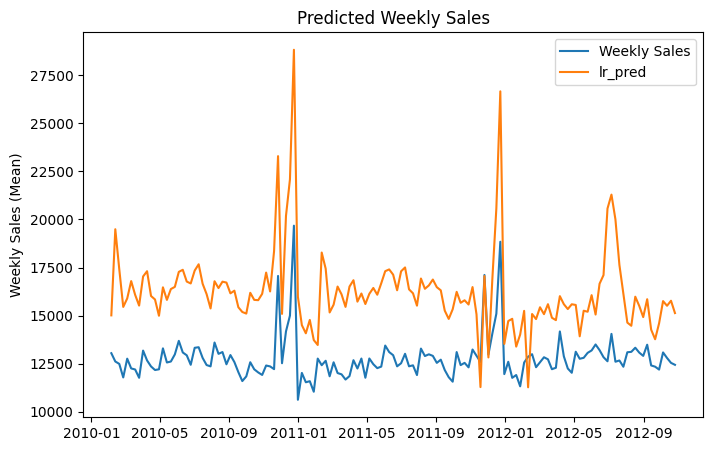

In [629]:
# Plotting the visualizations 

# Getting the predicted values from the regressor 
test['lr_pred'] = lr_pred

# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['lr_pred'])
mae = mean_absolute_error(test['Weekly_Sales'], test['lr_pred'])
r2 = r2_score(test['Weekly_Sales'], test['lr_pred'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'lr_pred': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['lr_pred'], label='lr_pred')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

In [524]:
# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['lr_pred'])
mae = mean_absolute_error(test['Weekly_Sales'], test['lr_pred'])
r2 = r2_score(test['Weekly_Sales'], test['lr_pred'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 14552.3832
Mean Absolute Error: 14552.3832
R-squared: -0.0529


In [386]:
xr = XGBRegressor()
xr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [387]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

y_pred = xr.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.17570389418527024
Mean Squared Error: 0.09323939406704697
R-squared: -0.02693981408536672


`Random Forest Regressor`

In [388]:
# Initializing Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [389]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

y_pred = rf.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.17688108574016032
Mean Squared Error: 0.09260992846674246
R-squared: -0.02000687234954812


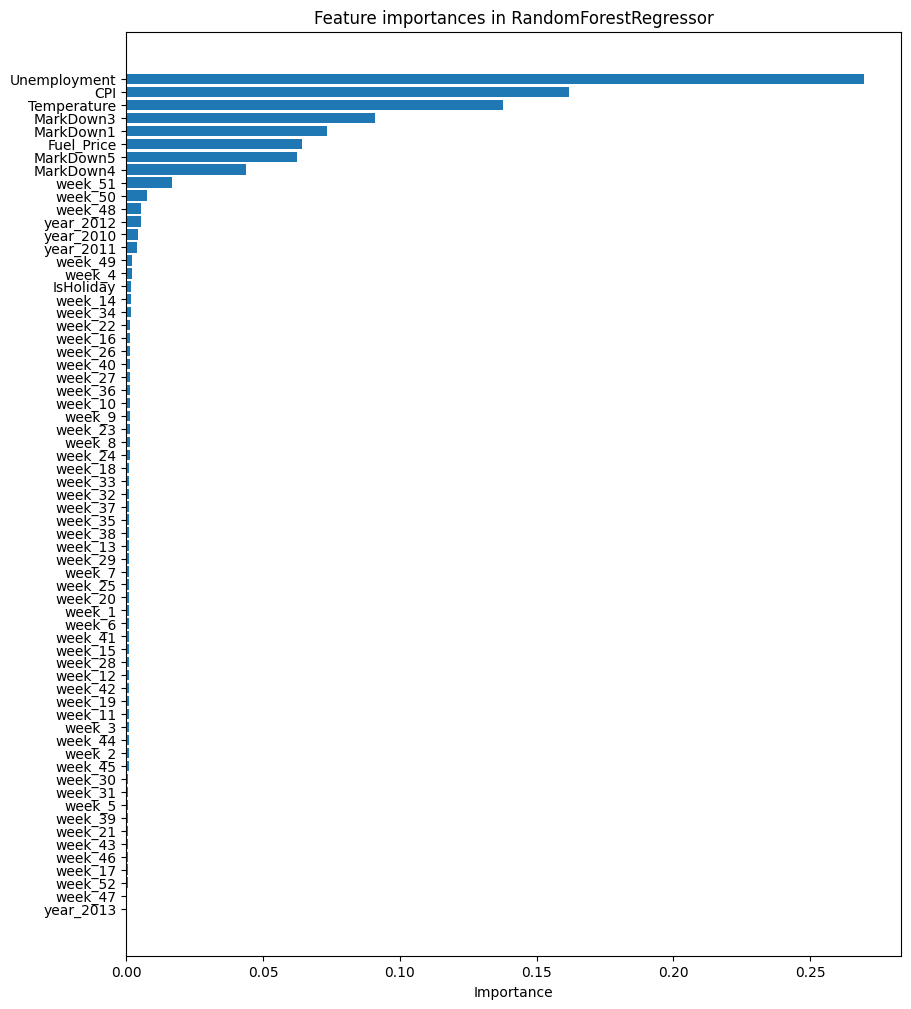

In [390]:
import matplotlib.pyplot as plt

feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()
8
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances in RandomForestRegressor')
plt.show()

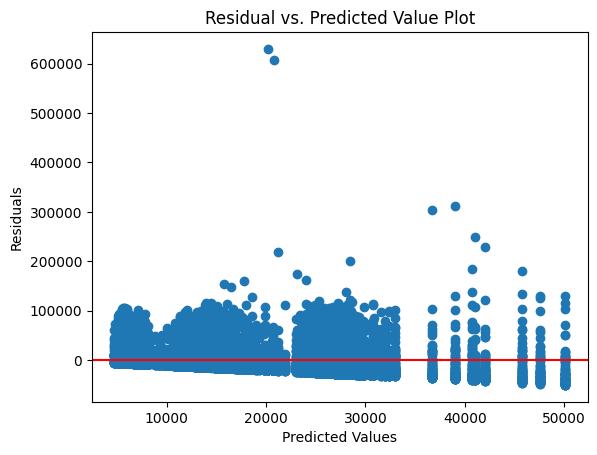

In [140]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual vs. Predicted Value Plot')
plt.show()

In [ ]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['RF_Predictions'] = rf.predict(X_test)

# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['RF_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

In [ ]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'RF_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['RF_Predictions'], label='RF_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`XGBoost regressor`

In [54]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['XGB_Predictions'] = xgb.predict(X_test)

# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['XGB_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['XGB_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['XGB_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 12052.5826
Mean Absolute Error: 12052.5826
Mean Absolute Percentage Error: 5890148028370498.0000
R-squared: 0.0038


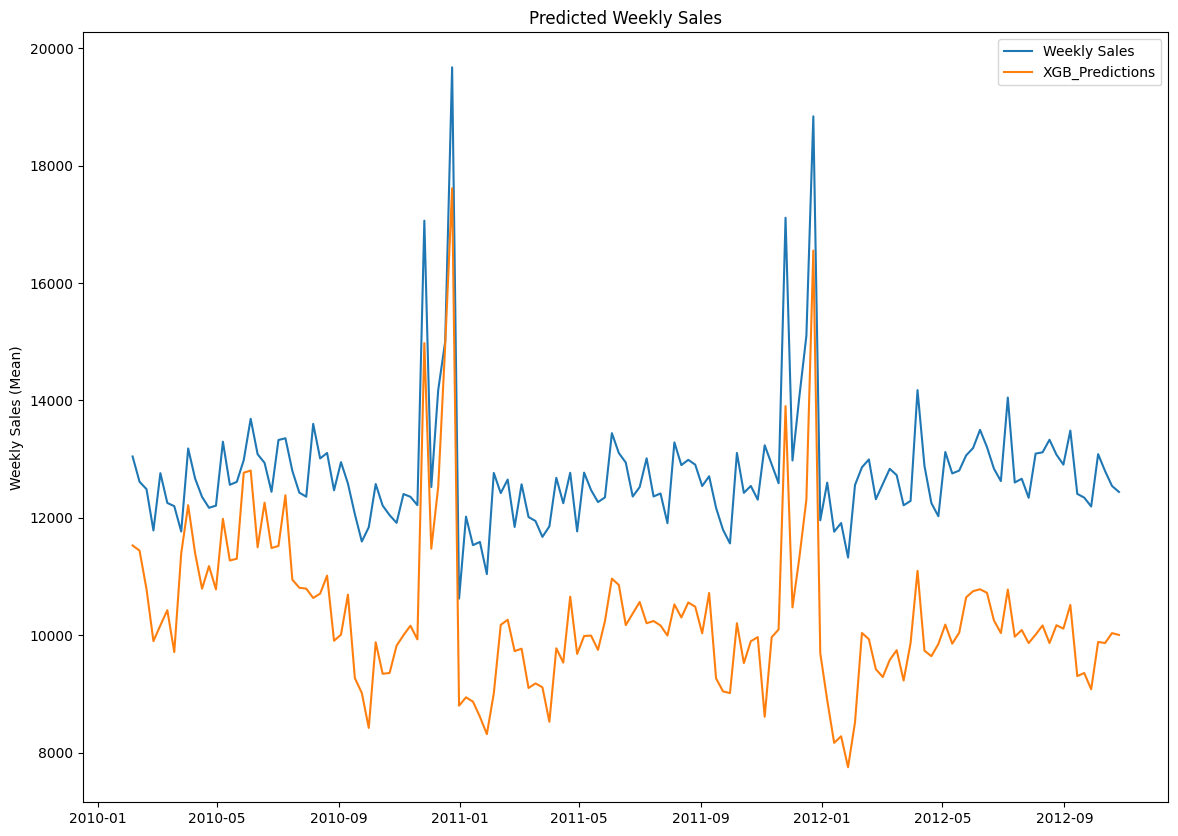

In [56]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'XGB_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['XGB_Predictions'], label='XGB_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()